In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 30
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = [IMAGE_SIZE, IMAGE_SIZE],
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


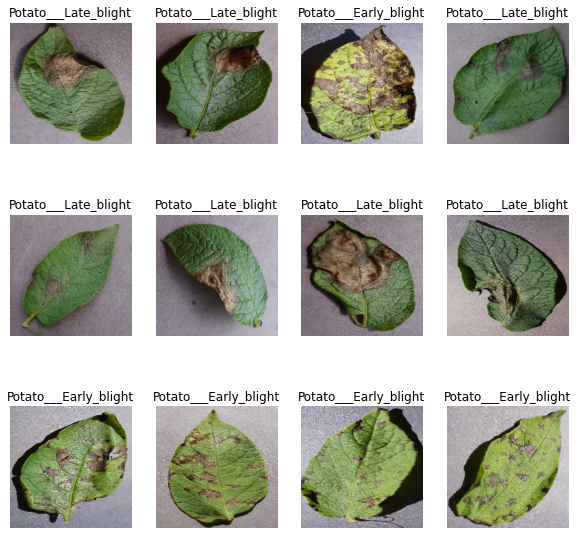

In [5]:
plt.figure(figsize=(10,10))
for image_b, label_b in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_b[i].numpy().astype("uint8"))
        plt.title(class_names[label_b[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
      dataset = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
      layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
      layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
      resize_and_rescale,
      data_augmentation,
      layers.Conv2D(32, (3,3), activation='relu', input_shape = shape),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(64, activation ='relu'),
      layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=shape)

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 127s 2s/step - loss: 0.9124 - accuracy: 0.5295 - val_loss: 0.8215 - val_accuracy: 0.5417
Epoch 2/30
54/54 [==============================] - 121s 2s/step - loss: 0.6740 - accuracy: 0.7025 - val_loss: 0.5466 - val_accuracy: 0.7865
Epoch 3/30
54/54 [==============================] - 119s 2s/step - loss: 0.5133 - accuracy: 0.7824 - val_loss: 0.3602 - val_accuracy: 0.8490
Epoch 4/30
54/54 [==============================] - 119s 2s/step - loss: 0.3705 - accuracy: 0.8565 - val_loss: 0.2777 - val_accuracy: 0.8906
Epoch 5/30
54/54 [==============================] - 119s 2s/step - loss: 0.2568 - accuracy: 0.8941 - val_loss: 0.1630 - val_accuracy: 0.9531
Epoch 6/30
54/54 [==============================] - 119s 2s/step - loss: 0.2316 - accuracy: 0.9103 - val_loss: 0.2481 - val_accuracy: 0.8906
Epoch 7/30
54/54 [==============================] - 119s 2s/step - loss: 0.1902 - accuracy: 0.9190 - val_loss: 0.1438 - val_accuracy: 0.9323
Epoch 8/30
54

First Image to predict: 
Actual label:  Potato___Early_blight
Predicted label:  Potato___Early_blight


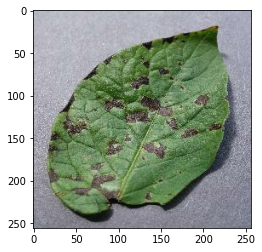

In [16]:
for images_b, labels_b in test_ds.take(1):

    image = images_b[0].numpy().astype('uint8')
    label = labels_b[0].numpy()

    print('First Image to predict: ')
    plt.imshow(image)
    print('Actual label: ',class_names[label])

    batch_prediction = model.predict(images_b)
    print('Predicted label: ',class_names[np.argmax(batch_prediction[0])])

In [17]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence 

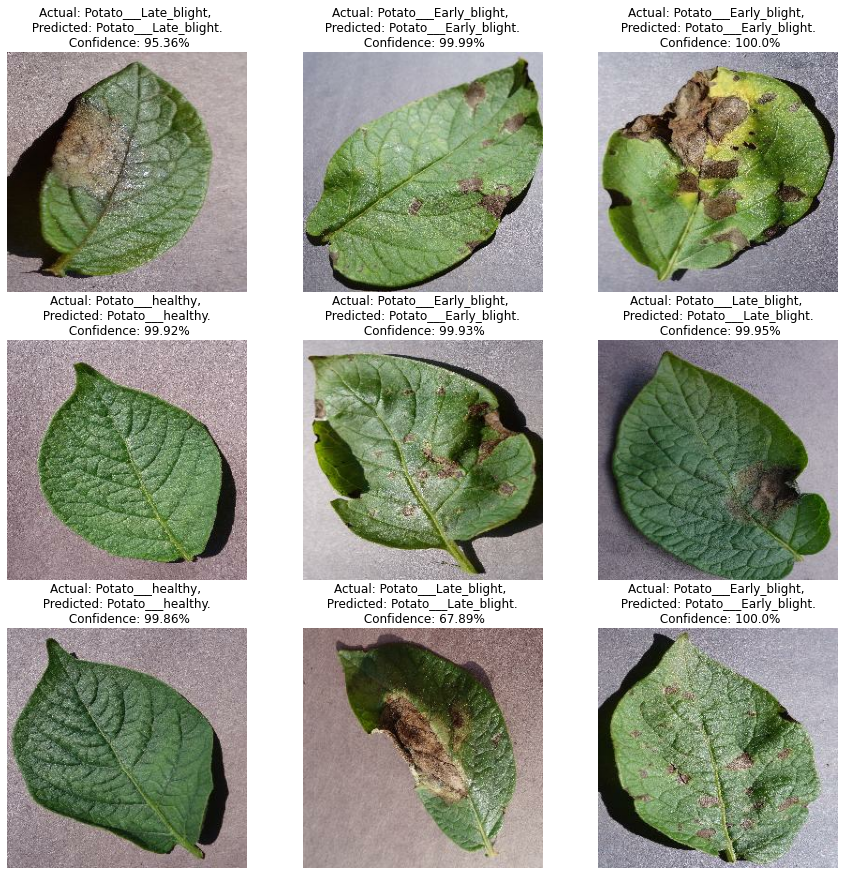

In [18]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
       ax = plt.subplot(3, 3, i + 1)
       plt.imshow(images[i].numpy().astype('uint8'))

       predicted_class, confidence = predict(model, images[i].numpy())
       actual_class = class_names[labels[i]]

       plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")

       plt.axis('off')

In [20]:
model_version = 3
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets
